# Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

[ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV

sns.set_palette("Blues")

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)


    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d',cmap="Blues")
    plt.show()

    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')


    cm_normalized_matrix = pd.DataFrame(data=cm_normalized, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=['Actual Negative:0','Actual Positive:1'])

    sns.heatmap(cm_normalized_matrix, annot=True, fmt='.3f',cmap="Blues")
    plt.show()

In [3]:
def get_metrics(y_test,y_pred):
    print("Accuracy: ", round(accuracy_score(y_test,y_pred),4))
    print("F1 score: ", round(f1_score(y_test,y_pred),4))
    print("Recall: ", round(recall_score(y_test,y_pred),4))
    print("Precision: ", round(precision_score(y_test,y_pred),4))

## Load data

In [4]:
ssa_l20_n10 = pd.read_csv("C:\\Users\\julia\\Documents\\UNICAMP\\TCC\\Final_datasets\\ssa_l20_n10.csv")

### Sanity checks

In [5]:
ssa_l20_n10['label'].value_counts()

label
1    8316
0    1920
Name: count, dtype: int64

In [6]:
ssa_l20_n10['bearing'].value_counts()

bearing
K001    320
K002    320
KI18    320
KI17    320
KI16    320
KI14    320
KI04    320
KB27    320
KB24    320
KB23    320
KA30    320
KA22    320
KA16    320
KA15    320
KA04    320
KI08    320
KI07    320
KI05    320
KI03    320
KI01    320
KA09    320
KA07    320
KA06    320
KA05    320
KA03    320
KA01    320
K006    320
K005    320
K004    320
K003    320
KI21    320
KA08    316
Name: count, dtype: int64

In [7]:
ssa_l20_n10['bearing'].unique()

array(['K001', 'K002', 'K003', 'K004', 'K005', 'K006', 'KA01', 'KA03',
       'KA05', 'KA06', 'KA07', 'KA08', 'KA09', 'KI01', 'KI03', 'KI05',
       'KI07', 'KI08', 'KA04', 'KA15', 'KA16', 'KA22', 'KA30', 'KB23',
       'KB24', 'KB27', 'KI04', 'KI14', 'KI16', 'KI17', 'KI18', 'KI21'],
      dtype=object)

In [8]:
ssa_l20_n10.columns

Index(['min_phase_current_1_ssa_0', 'max_phase_current_1_ssa_0',
       'median_phase_current_1_ssa_0', 'mean_phase_current_1_ssa_0',
       'rms_phase_current_1_ssa_0', 'std_phase_current_1_ssa_0',
       'range_phase_current_1_ssa_0', 'min_phase_current_2_ssa_0',
       'max_phase_current_2_ssa_0', 'median_phase_current_2_ssa_0',
       ...
       'rms_vibration_ssa_9', 'std_vibration_ssa_9', 'range_vibration_ssa_9',
       'rotation_speed', 'load_torque', 'radial_force', 'bearing', 'label',
       'label_detailed', 'category'],
      dtype='object', length=217)

In [9]:
# keep samples of the same configuration in the train or test df
unique_cat = ssa_l20_n10["category"].unique()
train_ids, test_ids = train_test_split(unique_cat, test_size=0.33, random_state=42)

train_df = ssa_l20_n10[ssa_l20_n10["category"].isin(train_ids)]
test_df = ssa_l20_n10[ssa_l20_n10["category"].isin(test_ids)]

## Using phase current data


In [10]:
# Split train and test
X_train_current = train_df.filter(like="current")
X_test_current = test_df.filter(like="current")
y_train_current = train_df['label']
y_test_current = test_df['label']

In [11]:
print(f"Samples train: {len(X_train_current)} \nSamples test: {len(X_test_current)}")

Samples train: 6800 
Samples test: 3436


## Grid Search

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

n_estimators: The number of trees in the forest.

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain

max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

min_samples_split: the minimum number of samples required to split an internal node

min_samples_leaf: the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

In [12]:
random_grid = {'n_estimators': np.array([10, 100, 250, 500, 1000]),
 'max_depth': [5, 10, 50, 100, 150, 300],
 'min_samples_split': [2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'criterion': ['gini', 'entropy']}

In [13]:
rf_base = RandomForestClassifier()
rf_random_current = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose=2,scoring='accuracy',
                               random_state=42, n_jobs = 4)
rf_random_current.fit(X_train_current, y_train_current)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 50, 100, 150, 300],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([  10,  100,  250,  500, 1000])},
                   random_state=42, scoring='accuracy', verbose=2)

In [14]:
rf_random_current.best_params_

{'n_estimators': 10,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'criterion': 'entropy'}

### Results of best estimator

In [15]:
y_pred_current = rf_random_current.best_estimator_.predict(X_test_current)
print(classification_report(y_test_current, y_pred_current))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       720
           1       0.92      0.99      0.96      2716

    accuracy                           0.93      3436
   macro avg       0.94      0.84      0.88      3436
weighted avg       0.93      0.93      0.92      3436



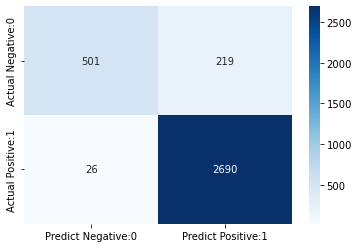

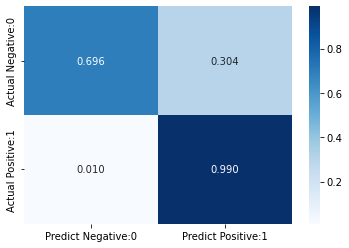

In [16]:
plot_confusion_matrix(y_test_current,y_pred_current)

In [17]:
get_metrics(y_test_current,y_pred_current)

Accuracy:  0.9287
F1 score:  0.9564
Recall:  0.9904
Precision:  0.9247


### Using vibration data

In [18]:
X_train_vib = train_df.filter(like="vib")
X_test_vib = test_df.filter(like="vib")
y_train_vib = train_df['label']
y_test_vib = test_df['label']

In [19]:
rf_base = RandomForestClassifier()
rf_random_vib = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose=2,scoring='accuracy',
                               random_state=42, n_jobs = 4)
rf_random_vib.fit(X_train_vib, y_train_vib)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 50, 100, 150, 300],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([  10,  100,  250,  500, 1000])},
                   random_state=42, scoring='accuracy', verbose=2)

In [20]:
rf_random_vib.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'criterion': 'entropy'}

### Results of best estimator

In [21]:
y_pred_vib = rf_random_vib.best_estimator_.predict(X_test_vib)
print(classification_report(y_test_vib, y_pred_vib))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       720
           1       0.97      1.00      0.98      2716

    accuracy                           0.97      3436
   macro avg       0.98      0.94      0.96      3436
weighted avg       0.97      0.97      0.97      3436



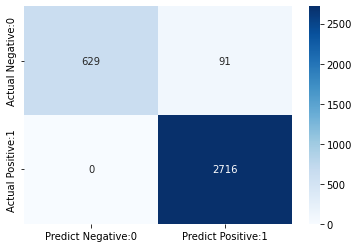

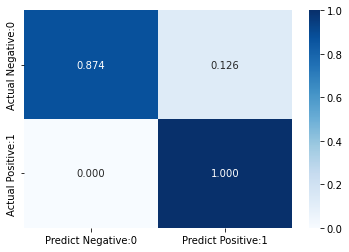

In [22]:
plot_confusion_matrix(y_test_vib, y_pred_vib)

In [23]:
get_metrics(y_test_vib,y_pred_vib)

Accuracy:  0.9735
F1 score:  0.9835
Recall:  1.0
Precision:  0.9676


### Using all data

In [24]:
X_train_all = train_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
X_test_all = test_df.drop(columns= {'rotation_speed', 'load_torque',
       'radial_force', 'bearing', 'label', 'label_detailed','category'})
y_train_all = train_df['label']
y_test_all = test_df['label']

In [25]:
rf_base = RandomForestClassifier()
rf_random_all = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose=2,scoring='accuracy',
                               random_state=42, n_jobs = 4)
rf_random_all.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 50, 100, 150, 300],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([  10,  100,  250,  500, 1000])},
                   random_state=42, scoring='accuracy', verbose=2)

In [26]:
rf_random_all.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'criterion': 'entropy'}

### Results of best estimator

In [27]:
y_pred_all = rf_random_all.best_estimator_.predict(X_test_all)
print(classification_report(y_test_all, y_pred_all))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       720
           1       0.97      1.00      0.98      2716

    accuracy                           0.97      3436
   macro avg       0.98      0.93      0.96      3436
weighted avg       0.97      0.97      0.97      3436



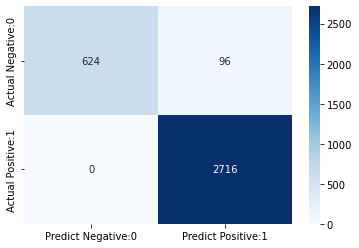

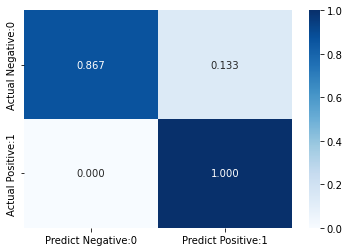

In [28]:
plot_confusion_matrix(y_test_all, y_pred_all)

In [29]:
get_metrics(y_test_all, y_pred_all)

Accuracy:  0.9721
F1 score:  0.9826
Recall:  1.0
Precision:  0.9659
